# the linear interpolation is super slow. Try to speed it up with numba as an optional step

In [1]:
from xarrayutils.vertical_coordinates import _coord_interp, linear_interpolation_regrid

/Users/juliusbusecke/miniconda/envs/test_env_xarrayutils/lib/python3.6/site-packages/distributed/utils.py:136: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  RuntimeWarning,


In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'
xr.set_options(cmap_sequential='cividis', display_style='html')
#import warnings
#warnings.filterwarnings("ignore")


In [3]:
# x = np.arange(17)+0.5
# y = np.arange(17)*4.0+9.0
# target_y = np.array([4.23, 6.0, 12.78, -9])


x = np.arange(17)+0.5
y = np.flip(np.arange(17)*4.0+9.0)
# y = np.arange(17)*4.0+9.0
target_x = np.array([-900, 4.23, 6.0, 12.78])

_coord_interp(y, x, target_x)

array([  nan, 58.08, 51.  , 23.88])

In [4]:
# try to wrap numpy interpolation into numba
from numba import jit

@jit(nopython=True)
def interpolate_numba(target_x, x, y):
    # mask out the out of range values
    return np.interp(target_x, x, y) # the padding is not supported

In [5]:
interpolate_numba(target_x, x, y)

array([73.  , 58.08, 51.  , 23.88])

In [6]:
%timeit _coord_interp(y, x, target_x)

95.8 µs ± 3.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%timeit interpolate_numba(target_x, x, y)

1.39 µs ± 54.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Holy cow! That was easy!
> Note that the padding inputs `left`/`right` are not supported for np.interp, but we can easily fix that I think.

Lets repeat this for a multidimensional array

In [8]:
# x = np.arange(17)+0.5
# y = np.arange(17)*4.0+9.0
# target_y = np.array([4.23, 6.0, 12.78, -9])

In [9]:
def broadcast_custom(arr):
    return arr[np.newaxis, np.newaxis,:].repeat(3,axis=0).repeat(6, axis=1)

In [10]:
xx = broadcast_custom(x)
yy = broadcast_custom(y)
target_xx = broadcast_custom(target_x)

# convert to da
da_xx = xr.DataArray(xx, dims=['something', 'smth', 'dangerzone'])
da_yy = xr.DataArray(yy, dims=['something', 'smth', 'dangerzone'])
da_target = xr.DataArray(target_x, dims=['daaangerzone'])

out = linear_interpolation_regrid(da_yy, da_xx, da_target, target_value_dim='daaangerzone', z_dim='dangerzone')

In [11]:
out.isel(something=0, smth=0).data

array([  nan, 58.08, 51.  , 23.88])

In [83]:
# # @jit(nopython=True)
# def interpolate_numba_multi(target_x, x, y, pad_left=None, pad_right=None):
#     # check shape does not work. For now assume this is only used with xr.apply_ufunc, which should handle the parallelization properly
    
#     def interpolate_single(single_target, single_x, single_y, pad_left, pad_right):
#         temp = np.interp(single_target, single_x, single_y)

#         left_idx = single_target <= single_x.min() # the notation here is crap. overhaul with consisten
#         temp[left_idx] = pad_left
        
#         right_idx = single_target >= single_x.max()
#         temp[right_idx] = pad_right
#         return temp
    
#     # capture original shape
#     shp = x.shape
#     target_shp = target_x.shape    
    
#     # convert all np arrays to max 2d.
#     # assumes that the last dimensions is the interpolation dimension (I think this is how xr.apply_ufuncs does this, by broadcasting the core dim
# #     to the end)

#     if len(shp) == 1:
#         if pad_left is None:
#             pad_left = np.array([np.nan])

#         if pad_right is None:
#             pad_right = np.array([np.nan])
        
#         # this is repetitive, but numba complains otherwise
#         single_target = target_x
#         single_x = x
#         single_y = y
#         single_pad_left = pad_left
#         single_pad_right = pad_right
        
#         temp = np.interp(single_target, single_x, single_y)

#         left_idx = single_target <= single_x.min() # the notation here is crap. overhaul with consisten
#         temp[left_idx] = single_pad_left
        
#         right_idx = single_target >= single_x.max()
#         temp[right_idx] = single_pad_right
        
#         return temp
        
#     else:
    
#         x = x.reshape((-1,shp[-1]))
#         y = y.reshape((-1,shp[-1]))
#         target_x = target_x.reshape((-1, target_shp[-1]))

#         if pad_left is None:
#             pad_left = np.ones_like(target_x[:,0]) * np.nan

#         if pad_right is None:
#             pad_right = np.ones_like(target_x[:,0]) * np.nan


#         interpolated = np.ones_like(target_x, dtype=target_x.dtype) * np.nan # is the dtype necessary?

#         for ii in range(x.shape[0]):
#             # this is repetitive, but numba complains otherwise
#             single_target = target_x[ii,:]
#             single_x = x[ii,:]
#             single_y = y[ii,:]
#             single_pad_left = pad_left[ii]
#             single_pad_right = pad_right[ii]
            

#             temp = np.interp(single_target, single_x, single_y)

#             left_idx = single_target <= single_x.min() # the notation here is crap. overhaul with consisten
#             temp[left_idx] = single_pad_left

#             right_idx = single_target >= single_x.max()
#             temp[right_idx] = single_pad_right
#             interpolated[ii,:] = temp


#         # mask out the out of range values
#         return interpolated.reshape(target_shp)

(3, 6, 17)

In [128]:
xx.reshape(3*6,17).shape

(18, 17)

In [130]:
tt = np.array(xx.shape[0:-1])
tt.prod()

18

In [131]:
from functools import reduce
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

@jit(nopython=True)
def interpolate_numba_multi(target_x, x, y, pad_left=None, pad_right=None):
    # check shape does not work. For now assume this is only used with xr.apply_ufunc, which should handle the parallelization properly
    
    # capture original shape
    shp = x.shape
    target_shp = target_x.shape 
    flat_shp = (np.prod(np.array(shp[0:-1])), shp[-1])
    flat_shp_target = (np.prod(np.array(target_shp[0:-1])), target_shp[-1])
    
    print(shp)
    # convert all np arrays to max 2d.
    # assumes that the last dimensions is the interpolation dimension (I think this is how xr.apply_ufuncs does this, by broadcasting the core dim
    # to the end)
    
    
#     x = x.reshape((-1,shp[-1]))# this was problematic for numba, lets try to explicitly pass array
    x = x.reshape(flat_shp)
    y = y.reshape(flat_shp)
    target_x = target_x.reshape(flat_shp_target)
    
    if pad_left is None:
        pad_left = np.ones_like(target_x[:,0]) * np.nan

    if pad_right is None:
        pad_right = np.ones_like(target_x[:,0]) * np.nan

    
    interpolated = np.ones_like(target_x, dtype=x.dtype) * np.nan# is the dtype necessary?
    
    for ii in range(x.shape[0]):
        temp = np.interp(target_x[ii,:], x[ii,:], y[ii,:])
        # pad left
        # ughhh this needs to know how y is sorted...
        left_idx = target_x[ii,:] <= x[ii,:].min() # the notation here is crap. overhaul with consisten
        temp[left_idx] = pad_left[ii]
        
        right_idx = target_x[ii,:] >= x[ii,:].max()
        temp[right_idx] = pad_right[ii]
        
                         
                        
        interpolated[ii,:] = temp
    
    
    # mask out the out of range values
    return interpolated.reshape(target_shp)

In [138]:
out_numba = interpolate_numba_multi(target_xx, xx, yy)
out_numba[0,0,:]

(3, 6, 17)


array([  nan, 58.08, 51.  , 23.88])

In [141]:
target_xx[0:2,:,:]

array([[[-900.  ,    4.23,    6.  ,   12.78],
        [-900.  ,    4.23,    6.  ,   12.78],
        [-900.  ,    4.23,    6.  ,   12.78],
        [-900.  ,    4.23,    6.  ,   12.78],
        [-900.  ,    4.23,    6.  ,   12.78],
        [-900.  ,    4.23,    6.  ,   12.78]],

       [[-900.  ,    4.23,    6.  ,   12.78],
        [-900.  ,    4.23,    6.  ,   12.78],
        [-900.  ,    4.23,    6.  ,   12.78],
        [-900.  ,    4.23,    6.  ,   12.78],
        [-900.  ,    4.23,    6.  ,   12.78],
        [-900.  ,    4.23,    6.  ,   12.78]]])

In [134]:
target_xx[0:2,0:2,:].shape

(2, 2, 4)

oooof, this is hard. If the passed arrays have 3 dimensions this works, but if the chunks are 2D or even 1d it fails...

In [142]:
out_numba = interpolate_numba_multi(target_xx[0:2,:,:], xx[0:2,:,:], yy[0:2,:,:])
out_numba

(2, 6, 17)


array([[[  nan, 58.08, 51.  , 23.88],
        [  nan, 58.08, 51.  , 23.88],
        [  nan, 58.08, 51.  , 23.88],
        [  nan, 58.08, 51.  , 23.88],
        [  nan, 58.08, 51.  , 23.88],
        [  nan, 58.08, 51.  , 23.88]],

       [[  nan, 58.08, 51.  , 23.88],
        [  nan, 58.08, 51.  , 23.88],
        [  nan, 58.08, 51.  , 23.88],
        [  nan, 58.08, 51.  , 23.88],
        [  nan, 58.08, 51.  , 23.88],
        [  nan, 58.08, 51.  , 23.88]]])

In [143]:
out_numba = interpolate_numba_multi(target_x, x, y)
out_numba

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of BoundFunction(array.reshape for array(float64, 1d, C)) with parameters (Tuple(float64, int64))
 * parameterized
[1] During: resolving callee type: BoundFunction(array.reshape for array(float64, 1d, C))
[2] During: typing of call at <ipython-input-131-bf3ed71ab624> (23)


File "<ipython-input-131-bf3ed71ab624>", line 23:
def interpolate_numba_multi(target_x, x, y, pad_left=None, pad_right=None):
    <source elided>
#     x = x.reshape((-1,shp[-1]))# this was problematic for numba, lets try to explicitly pass array
    x = x.reshape(flat_shp)
    ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [69]:
# does np.interp sort?


x = np.arange(17)+0.5
y = np.flip(np.arange(17)*4.0+9.0)
y = np.arange(17)*4.0+9.0
target_x = np.array([-900, 4.23, 6.0, 12.78])

np.interp(target_x, x, y, left=-500, right=100)

array([-500.  ,   23.92,   31.  ,   58.12])

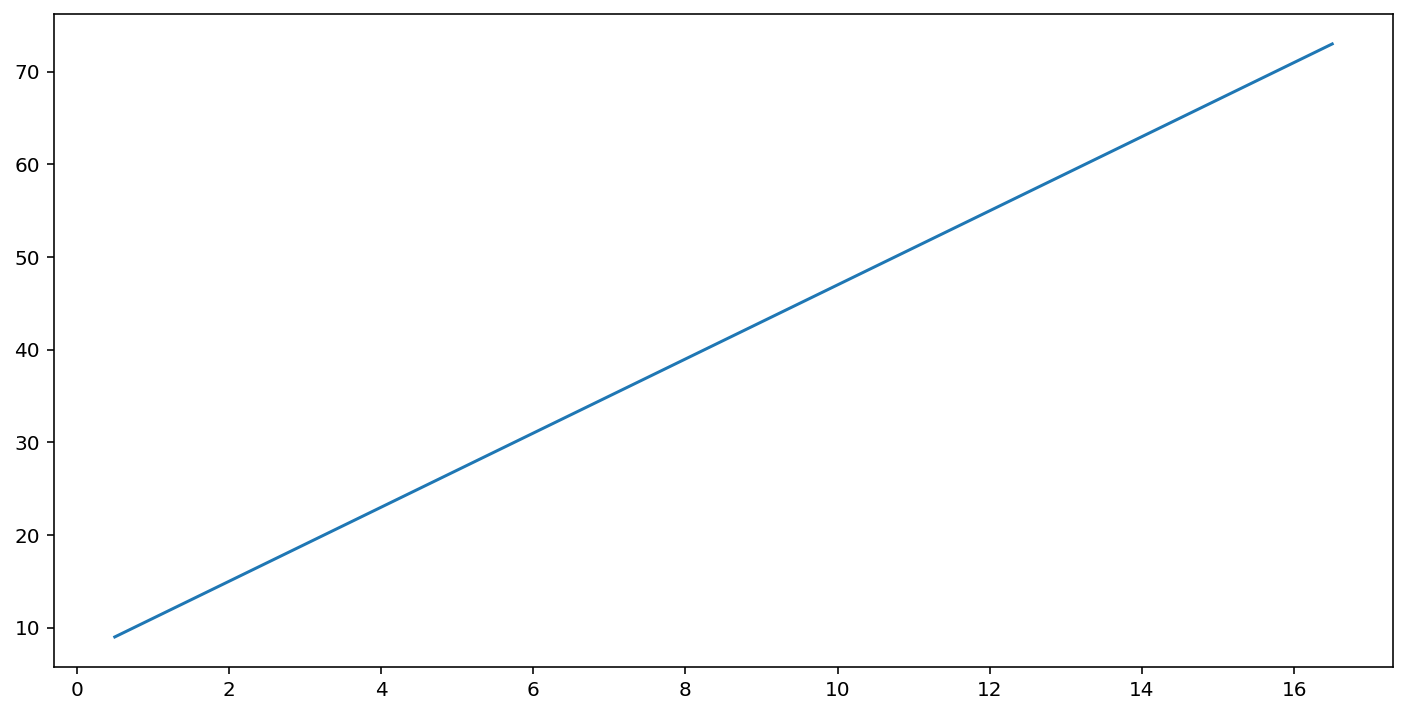

In [66]:
plt.plot(x,y)